## Analyzing borrowers’ risk of defaulting

This report is focused on identifying a relationship between customer characteristics (e.g. children count, purpose of loan, education) and failure to pay back a loan. Skill displayed here include basic data cleaning and lemmatization (ntlk). 

Report completed: March 22, 2020

### Looking at the general information. 

In [1]:
import pandas as pd 
import numpy as np
df = pd.read_csv('credit_scoring_eng.csv') #csv not included due to private data 
df.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,bachelor's degree,0,married,0,F,employee,0,40620.102,purchase of the house
1,1,-4024.803754,36,secondary education,1,married,0,F,employee,0,17932.802,car purchase
2,0,-5623.422610,33,Secondary Education,1,married,0,M,employee,0,23341.752,purchase of the house
3,3,-4124.747207,32,secondary education,1,married,0,M,employee,0,42820.568,supplementary education
4,0,340266.072047,53,secondary education,1,civil partnership,1,F,retiree,0,25378.572,to have a wedding
5,0,-926.185831,27,bachelor's degree,0,civil partnership,1,M,business,0,40922.170,purchase of the house
6,0,-2879.202052,43,bachelor's degree,0,married,0,F,business,0,38484.156,housing transactions
7,0,-152.779569,50,SECONDARY EDUCATION,1,married,0,M,employee,0,21731.829,education
8,2,-6929.865299,35,BACHELOR'S DEGREE,0,civil partnership,1,F,employee,0,15337.093,having a wedding
9,0,-2188.756445,41,secondary education,1,married,0,M,employee,0,23108.150,purchase of the house for my family


In [2]:
df.loc[df['debt'] != 0]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
14,0,-1844.956182,56,bachelor's degree,0,civil partnership,1,F,business,1,26420.466,buy residential real estate
32,0,-4649.910832,34,SECONDARY EDUCATION,1,civil partnership,1,F,employee,1,22249.194,having a wedding
38,0,-597.881827,25,bachelor's degree,0,unmarried,4,M,employee,1,30759.568,education
55,0,NaN,54,secondary education,1,civil partnership,1,F,retiree,1,NaN,to have a wedding
75,1,-2953.151948,38,secondary education,1,married,0,M,employee,1,13109.661,real estate transactions
...,...,...,...,...,...,...,...,...,...,...,...,...
21494,0,-960.095747,39,secondary education,1,civil partnership,1,M,business,1,28219.135,supplementary education
21511,0,-612.569129,29,bachelor's degree,0,civil partnership,1,F,employee,1,22410.956,buying property for renting out
21515,1,-467.685130,28,secondary education,1,married,0,F,employee,1,17517.812,to become educated
21522,1,-2113.346888,38,secondary education,1,civil partnership,1,M,employee,1,14347.610,property


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


### Conclusion

12 columns, 21525 rows

Quantitative values: children, days_employed (float), education_id, family_status_id, debt, total_income 

Categories: education, family_status, gender, income_type, purpose, education_id 

Issues seen so far: 
- Days_employed column is a bit confusing from the unpleasing decimals and negative signs. 
- We can already see that education has issues in case-sensitivity. 
- Education_id is a [0,1] value where it is providing a 1 for only secondary education 
- family_status_id is a [0,1] value where it providing a 1 for civil partnership 
- total_income is not a pleasing display with all the decimal points 
- purpose column has an error where 'to have a wedding' and 'having a wedding' are the same thing but will not be aggregated together

## Data preprocessing

### Processing missing values

#### Processing missing values: Null values

In [4]:
#Find columns that have missing values
#Looking for columns that have values of zero and would not make sense
columnsWithNaN = []
columnsWithZero =[]
for x in df.columns:
    if df[df[x].isnull()].empty == False: 
            columnsWithNaN.append(x)
    if 0 in df[x]: 
            columnsWithZero.append(x)
print('NaN:', columnsWithNaN)

NaN: ['days_employed', 'total_income']


In [5]:
medEmployed = df['days_employed'].median()
medIncome = df['total_income'].median()
df['days_employed'] = df['days_employed'].fillna(medEmployed)
df['total_income'] = df['total_income'].fillna(medIncome)

#Confirmation that the null values were eliminated
#df[df['days_employed'].isnull()].count()

Since the missing values are quantitative, will use median to fill in null values to estimate

#### Processing missing values: Unreasonable zero values

My current plan is to just replace them with NotANumber values instead of having them as zero

In [6]:
df.loc[df['dob_years'] == 0, 'dob_years'] = np.nan
print('Count of zeroes in the dob_years column:', df.loc[df.loc[:, 'dob_years'] == 0]['dob_years'].count())

Count of zeroes in the dob_years column: 0


#### Processing missing values: Unreasonable negative values 

Manual checking for column "children" using .value_counts() showed that there are negative values

Below is the modified .value_counts() for the "children" column

In [7]:
df.loc[df['children'] == -1, 'children'] = 1 
df['children'].value_counts()

0     14149
1      4865
2      2055
3       330
20       76
4        41
5         9
Name: children, dtype: int64

#### Processing missing values: Outlier data 

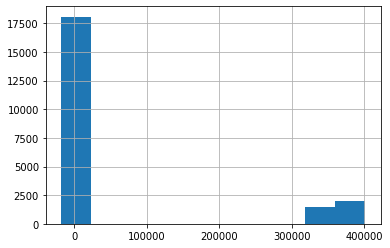

In [8]:
df['days_employed'].hist()

In the days_employed column, there are some entries that are extremely far from the rest of the distribution

Text(0, 0.5, 'Frequency')

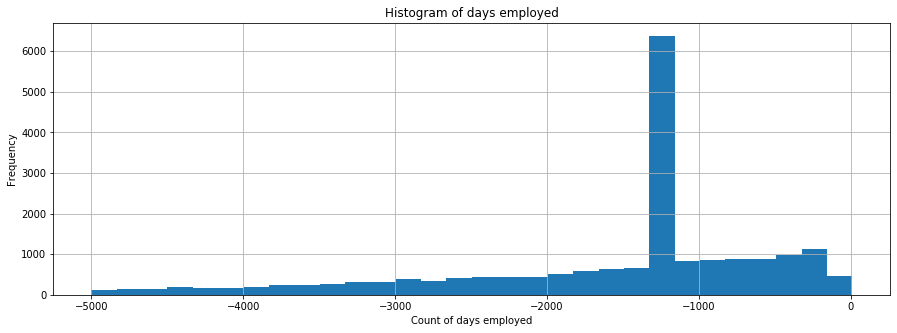

In [9]:
import matplotlib.pyplot as plt
#'All entries of days_employed greater than 300000 will be replaced by the median'
medEmployed = df['days_employed'].median()
df.loc[df['days_employed'] > 300000, 'days_employed'] = medEmployed

#Confirmation that the outliers were eliminated values were eliminated
df['days_employed'].hist(figsize=(15,5),bins=30,range=(-5000,10))
plt.title('Histogram of days employed')
plt.xlabel('Count of days employed')
plt.ylabel('Frequency')

In [10]:
df.loc[df['children'] == 20, 'children'] = 2

Also, it was noticed that there are many counts of specifically 20 for children. This is assumed to be 2 instead

### Processing missing values: Conclusion

##### Null Values
It was identified that columns 'days_employed' and 'total_income' had null values through a loop that checked for null values and validated with the .count() method. These were remedied by replacing them with the median values of their respective column. Possible cases of this is from human error of the data input or an error from exporting the data to a csv file. 

##### Unreasonable zero values
Through manual checking using the .loc method and condition ==0, we also found that column 'dob_years' had values of zero in them. This was modified into empty string values. I believe the possible case with this is from a technical error where it was supposed to take the delta between today's date and their date of birth, but had a calculation issue. 

##### Unreasonable negative values 
Through manual checking using the .value_counts() method on column 'children', I found a negative value for it. This does not make sense because you can not have negative children. I remedied this by locating all items within the column that was equal to -1 and changed it to 1. I believe it was most likely a technical issue from exporting of the csv file or calculation.

##### Outlier data
The distribution of the column 'days_employed' showed extremely high values that were far from the rest of the values. These values were identified to be 300k+ days which translates to over 800 years which is unreasonable. This was remedied by finding all values that were greater than 300000 days and replacing them with the median value. It is possible it could have been a human error from inputting too many numbers. It is more likely for it to be a technical error from exporting of the csv file or calculation.

The same concept is applied to the high number of counts of people who have 20 children. I would believe this if there were a smaller amount and more counts of children inbetween 5 and 20. This was remedied by changing values of 20 children to 2. This is most likely a human error accidentally inputting a zero afterwards.

### Data type replacement

Here we will change the float64 data types to int64 (integer) data types

In [11]:
df['days_employed'] = df['days_employed'].astype('int')
df['total_income'] = df['total_income'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     21525 non-null  int32  
 2   dob_years         21424 non-null  float64
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      21525 non-null  int32  
 11  purpose           21525 non-null  object 
dtypes: float64(1), int32(2), int64(4), object(5)
memory usage: 1.8+ MB


In [12]:
# print('trying to get absolute values for the negative items ')
# print('Manual checking for column "days_employed" using .value_counts() saw some negative entries as well')
# # for index, row in df.iterrows(): 
# #     if row['days_employed'] < 0:
# #         row['days_employed'] = abs(row['days_employed'])
# #     break
# # print(df['days_employed'].head())
# newDaysEmployed = []

# for row in df['days_employed']:
#     newDaysEmployed.append(abs(row))

# df['days_employed'] = newDaysEmployed
# df.head()

### Data type replacement: Conclusion

#### Method
The determined columns that were using real number data type were days_employed and total_income which can be seen in df.info(). After identifying which columns were float64, the .astype() method with an argument of int was applied to them. 

#### Why
Some reasons this was applied include 
-  Legibility. The data is hard to read with so many numbers after the decimal point
-  The data does not benefit to know that a person has been unemployed for 240.5 days as opposed to 240 days
-  Decrease the file size and processing time?

### Processing duplicates

Here is the count of duplicates per column

In [13]:
qualitativeCol = ['education', 'family_status', 'gender', 'income_type','purpose']
for x in qualitativeCol:
    #print(x, '--', df.duplicated(x).sum()) 
    print(df[x].value_counts())
    print('----------------')

secondary education    13750
bachelor's degree       4718
SECONDARY EDUCATION      772
Secondary Education      711
some college             668
BACHELOR'S DEGREE        274
Bachelor's Degree        268
primary education        250
Some College              47
SOME COLLEGE              29
PRIMARY EDUCATION         17
Primary Education         15
graduate degree            4
GRADUATE DEGREE            1
Graduate Degree            1
Name: education, dtype: int64
----------------
married              12380
civil partnership     4177
unmarried             2813
divorced              1195
widow / widower        960
Name: family_status, dtype: int64
----------------
F      14236
M       7288
XNA        1
Name: gender, dtype: int64
----------------
employee                       11119
business                        5085
retiree                         3856
civil servant                   1459
entrepreneur                       2
unemployed                         2
student                    

From this count of data for qualtitative columns, we can understand the kind of data we are getting. Below is a quick assessment:
- Education: Lots of duplicated data that is mostly case-sensitivity issues. 
- Family status: No apparant issues 
- Gender: No apparant issues 
- Income Type: No issues other than the typo for 'unempoyed' which should be 'unemployed'
- Purpose: Lots of repeated entries such as 'to own a car' and 'to buy a car'. 

#### Processing duplicates: 'education' 

In [14]:
print('This modified all items in the education column to be lowercase, which now has grouped items accurately')
df['education'] = df['education'].str.lower()
df['education'].value_counts()

This modified all items in the education column to be lowercase, which now has grouped items accurately


secondary education    15233
bachelor's degree       5260
some college             744
primary education        282
graduate degree            6
Name: education, dtype: int64

#### Processing duplicates: 'purpose'

This natural language processor will be addressed in the lemmatization portion of the project

### Processing duplicates: Conclusion

##### Method 
To find the duplicates, I ran a loop through the qualitative columns because it is difficult to assess if quantitiatve duplicates are genuine or not at first glance. This loop provided the value_counts to let me manually see if there were any duplicates in these columns. I was able to visually identify that 'education' and 'purpose' had duplicated entries. The issues were case-sensitivity and different wording respectively for the columns.

To remedy the duplicates, I modified the entire 'education' column to be all lower case by using the .str.lower() method. I validated my solution by calling .value_counts for the 'education' column again and saw that all entries were in the same case format. 

##### Possible Reasons
I believe that this issue is definitely a human error. When a client is submitting their information, they must have had a text box entry for their education which allowed for case sensitivity room for error. Some clients were inputting their education in different case formats that brought this error. 

### Lemmatization

In [15]:
import nltk 
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from collections import Counter 
lemmatizer = WordNetLemmatizer()
#purpose_lemmas = []
            
def lemmaFunction(row):
    words = nltk.word_tokenize(row)
    return [lemmatizer.lemmatize(word) for word in words]
#not using the pos value 

df['purpose_lemma'] = df['purpose'].apply(lemmaFunction)
df['purpose_lemma'].value_counts()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Denzo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Denzo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 1652, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[car]                                            973
[wedding, ceremony]                              797
[having, a, wedding]                             777
[to, have, a, wedding]                           774
[real, estate, transaction]                      676
[buy, commercial, real, estate]                  664
[housing, transaction]                           653
[buying, property, for, renting, out]            653
[transaction, with, commercial, real, estate]    651
[purchase, of, the, house]                       647
[housing]                                        647
[purchase, of, the, house, for, my, family]      641
[construction, of, own, property]                635
[property]                                       634
[transaction, with, my, real, estate]            630
[building, a, real, estate]                      626
[buy, real, estate]                              624
[building, a, property]                          620
[purchase, of, my, own, house]                

In [16]:
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_lemma
0,1,-8437,42.0,bachelor's degree,0,married,0,F,employee,0,40620,purchase of the house,"[purchase, of, the, house]"
1,1,-4024,36.0,secondary education,1,married,0,F,employee,0,17932,car purchase,"[car, purchase]"
2,0,-5623,33.0,secondary education,1,married,0,M,employee,0,23341,purchase of the house,"[purchase, of, the, house]"
3,3,-4124,32.0,secondary education,1,married,0,M,employee,0,42820,supplementary education,"[supplementary, education]"
4,0,-1203,53.0,secondary education,1,civil partnership,1,F,retiree,0,25378,to have a wedding,"[to, have, a, wedding]"


##### Explanation
Using the natural language toolkit library, we are able to tokenize each row entry's response to the 'purpose' column. This mean we can extract each word out of the sentence into a list. After the the entry is split by each word, the lemmatize method is applied to identify the nouns of the tokenized list to return a list of only the nouns. This congregated into a function and is applied to every row in the dataframe using the .apply method to generate a new column with the lemmas of the entry. 

We manually define the main topics as car, wedding, estate, and education

In [17]:
def topicDefine(row):
    if 'car' in row:
        return 'car'
    elif ('education' in row) or ('university' in row) or ('educated' in row):
        return 'education'
    elif ('wedding' in row):
        return 'wedding'
    elif ('property' in row) or ('estate' in row) or ('house' in row) or ('housing' in row):
        return 'house' 
    else:
        return 'null'
    
df['topic'] = df['purpose_lemma'].apply(topicDefine)
df['topic'].value_counts()

house        10840
car           4315
education     4022
wedding       2348
Name: topic, dtype: int64

### Lemmatization: Conclusion

The original function identified the main topics to feature car, wedding ,estate, and education. Manually looking through the lemmas from the purpose_lemma column, I found the nouns and verbs that would reference these topics. A function is used to loop through each row of the 'purpose_lemma" column to find the topic it is referencing based conditions of nouns and verbs. This categorized these purposes into 4 categories. You can see their counts above. The main one is to purchase a house and the least likely one is to celebrate a wedding.

### Categorizing Data

Looking at the questions that need to be addressed below, we will need to make categorizations for 

##### Categorizing Data: Age

We can see the distribution of ages here. We will classify them in typical age group buckets

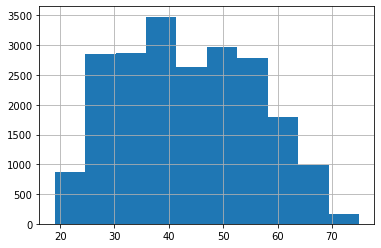

In [18]:
df['dob_years'].hist()

In [19]:
def age_group(age):
    if age < 30:
        return 'Young Adult'
    elif age < 45:
        return 'Adult'
    elif age < 65:
        return 'Older Adult'
    else:
        return 'Elderly'
    
df['age_group'] = df['dob_years'].apply(age_group)
df['age_group'].value_counts()

Older Adult    8795
Adult          8547
Young Adult    3183
Elderly        1000
Name: age_group, dtype: int64

##### Categorizing Data: Income

In [20]:
def income_group(income):
    if income < 60000:
        return 'LessThan60'
    elif income < 100000:
        return 'LessThan100'
    elif income < 120000:
        return 'LessThan150'
    elif income < 200000:
        return 'LessThan200'
    else:
        return 'MoreThan200'
    
df['income_group'] = df['total_income'].apply(income_group)
df['income_group'].value_counts()

LessThan60     20853
LessThan100      573
LessThan150       50
LessThan200       38
MoreThan200       11
Name: income_group, dtype: int64

### Characteristic Analysis

- Is there a relation between having kids and repaying a loan on time?

In [21]:
df.groupby('children')['debt'].agg(['count','mean', 'median'])

,count,mean,median
children,,,
0,14149,0.075129,0
1,4865,0.091470,0
2,2131,0.094791,0
3,330,0.081818,0
4,41,0.097561,0
5,9,0.000000,0


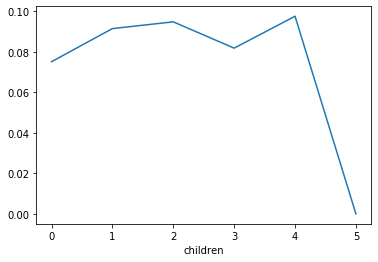

In [22]:
df.groupby('children')['debt'].mean().plot()

### Conclusion: Kids and paying debt on time

By taking the average of how many clients who have defaulted on their debt grouped by the number of children they have, we get a ratio of how likely each bucket would pay their debt on time. Overall it seems like all counts of children have a low likely of not repaying their loan on time with 0.0976 being the highest ratio. 

There is a slight increase of likelihood to default on their debt from groups of children from 0 to 2, but there is only a delta of 0.019662 between them which is still important to notice. The ratio actually decreases at counts of 3 children, but then rises back at 4, which shows there is only a slightly positive relation. The counts of each group decreases for greater numbers of children (which makes sense since it's difficult to have a big family) so the reliability of the data decreases as well. We should not consider counts of 5 children because we only have 9 rows with this kind of data. 

The data makes sense because those who do not have children have less financial responsibility compared to those raising a family, so they will be more likely to pay a loan back on time. Having 1 or 2 children adds more fiscal pressure and makes it more difficult to pay a loan back on time. From 3 children and onwards, the count of these entries start to become scarce, but still slightly follows the same idea that more children slightly increases likeliness to not pay debt on time. 

- Is there a relation between marital status and repaying a loan on time?

In [23]:
df.groupby('family_status')['debt'].agg(['count', 'mean', 'median'])

,count,mean,median
family_status,,,
civil partnership,4177,0.092890,0
divorced,1195,0.071130,0
married,12380,0.075202,0
unmarried,2813,0.097405,0
widow / widower,960,0.065625,0


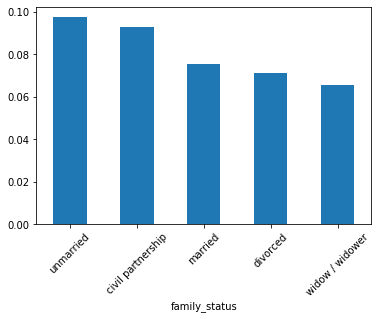

In [24]:
df.groupby('family_status')['debt'].mean().sort_values(ascending = False).plot(kind = 'bar', rot = 45)

In [25]:
df.pivot_table(index = 'family_status', columns = 'age_group', values = 'debt', aggfunc = ['count','mean'])

count                                      mean            \
age_group         Adult Elderly Older Adult Young Adult     Adult   Elderly   
family_status                                                                 
civil partnership  1761     164        1567         685  0.107325  0.060976   
divorced            451      59         589          96  0.066519  0.084746   
married            5258     500        5140        1482  0.084062  0.052000   
unmarried           981     102         812         918  0.111111  0.029412   
widow / widower      96     175         687           2  0.062500  0.074286   

                                           
age_group         Older Adult Young Adult  
family_status                              
civil partnership    0.075941    0.102190  
divorced             0.061121    0.145833  
married              0.058560    0.109312  
unmarried            0.072660    0.112200  
widow / widower      0.064047    0.000000

### Conclusion: Martial status and paying debt on time

By grouping by martial status, and looking for the average liklihood of defaulting on debt, we get a ratio for the buckets. From all the martial status categories, there is a range of 0.065 to 0.097 of the averages of paying debt on time. We can see that there is a relation with the high range that are based on buckets. The highest liklihood to not pay debt on time is for the 'unmarried' category of 0.974. My hypothesis is that many young adults are unmarried and are irresponsible with paying back their debt.

Civil partnership is the second highest with 0.07 which is surprising. The categories of married, divorced, and widow/widower have less than 0.075 likelihood to not pay back their loan, showing a strong relation of martial status and default probability. My assumption is that they are all older client who are more mature with their finances. 

- Is there a relation between income level and repaying a loan on time?

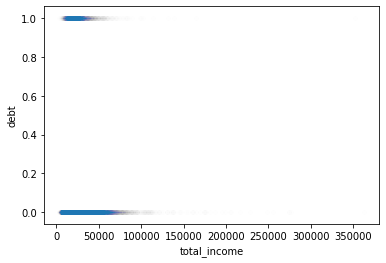

In [26]:
df.plot(kind = 'scatter', x = 'total_income', y = 'debt', alpha = 0.002)

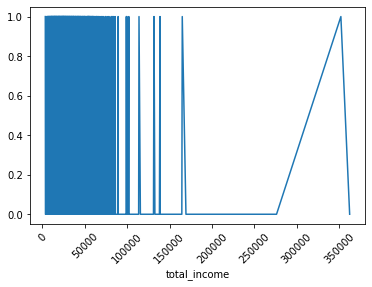

In [27]:
df.groupby('total_income')['debt'].mean().plot(rot = 45)

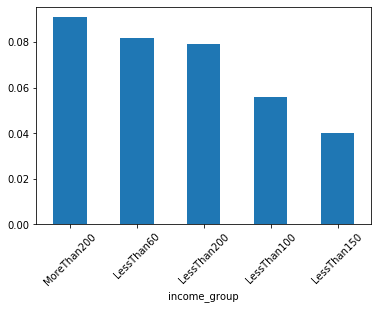

In [28]:
df.groupby('income_group')['debt'].mean().sort_values(ascending = False).plot(kind = 'bar',rot = 45)

In [29]:
df.pivot_table(index = 'income_group', columns = 'age_group', values = 'debt', aggfunc = ['count','mean'])

count                                      mean            \
age_group      Adult Elderly Older Adult Young Adult     Adult   Elderly   
income_group                                                               
LessThan100    263.0    13.0       228.0        69.0  0.060837  0.000000   
LessThan150     24.0     2.0        17.0         7.0  0.041667  0.000000   
LessThan200     24.0     NaN        13.0         1.0  0.000000       NaN   
LessThan60    8227.0   985.0      8535.0      3106.0  0.092136  0.057868   
MoreThan200      9.0     NaN         2.0         NaN  0.111111       NaN   

                                      
age_group    Older Adult Young Adult  
income_group                          
LessThan100     0.048246    0.072464  
LessThan150     0.058824    0.000000  
LessThan200     0.153846    1.000000  
LessThan60      0.063855    0.110431  
MoreThan200     0.000000         NaN

### Conclusion

I have divided the income groups into 5 different categories in an earlier section. Income groups are needed because the line chart without it is difficult to understand. 

Based on the bar chart, we can see that those who are making from 150k - 200k have the highest likelihood of not paying their debt. This is surprising since they have a high income. My assumption is that they are making large jumps to build a business or some other sort of high risk high reward investment. 

The second highest probability of not paying debt on time is from the 60k - 100k range. My assumption is that they are using loans to break into that six figure range. 

A significant decrease is seen from 100k - 150k income range to 200k+. My guess is that those who have over 200k+ in total income are risk averse and are playing it safe with their finances. 

The least likely group to not pay their debt is the <60k range. Being the smallest income group, I imagine they are also playing it safe with the amount they have. 

- How do different loan purposes affect on-time repayment of the loan?

In [30]:
df.groupby('topic')['debt'].agg(['count', 'mean', 'median'])

,count,mean,median
topic,,,
car,4315,0.093395,0
education,4022,0.091994,0
house,10840,0.072140,0
wedding,2348,0.079216,0


In [31]:
df.pivot_table(index = 'topic', columns = 'income_group', values = 'debt', aggfunc = ['count','mean'])

count                                                 \
income_group LessThan100 LessThan150 LessThan200 LessThan60 MoreThan200   
topic                                                                     
car                  123           7           9       4175           1   
education            106           8           5       3902           1   
house                294          29          22      10488           7   
wedding               50           6           2       2288           2   

                    mean                                                 
income_group LessThan100 LessThan150 LessThan200 LessThan60 MoreThan200  
topic                                                                    
car             0.048780    0.000000    0.000000   0.095090    0.000000  
education       0.056604    0.125000    0.400000   0.092517    0.000000  
house           0.057823    0.034483    0.045455   0.072654    0.142857  
wedding         0.060000    0.000000    0.000000   0.079983    0.000000

### Conclusion

A loan purpose of a car has the highest likelihood to not pay back a loan on time. My guess is that it is a luxury and could be considered fisically irresponsible. 
Loan used for education has an average of 0.092 

In [32]:
#Reference code
#lemma 
#     for row in df['purpose']:
#         words = nltk.word_tokenize(row)
#         for word in words:
#             purpose_lemmas.append(lemmatizer.lemmatize(word))